# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles 
This is the code for the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang, A. Moubayed, I. Hamieh and A. Shami, "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles," 2019 IEEE Global Communications Conference (GLOBECOM), 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9013892.  

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,Imputer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.

In [3]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')

In [4]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,32215,4,2,112,152,28,28,28.0,0.00000,76,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,324,2,2,84,362,42,42,42.0,0.00000,181,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,82,2,1,31,6,31,0,15.5,21.92031,6,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,1048635,6,2,192,256,32,32,32.0,0.00000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df.Label.value_counts()

BENIGN          2273097
DoS              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: Label, dtype: int64

### Data sampling
Due to the space limit of GitHub files, we sample a small-sized subset for model learning using random sampling

In [6]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [7]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [8]:
df_s = df_s.sort_index()

In [9]:
# Save the sampled dataset
df_s.to_csv('./data/CICIDS2017_sample.csv',index=0)

### Preprocessing (normalization and padding values)

In [10]:
df = pd.read_csv('./data/CICIDS2017_sample.csv')

In [11]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

C:\Users\41364\AppData\Roaming\Python\Python35\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


### split train set and test set

In [18]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [19]:
X_train.shape

(45328, 77)

In [20]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [21]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [22]:
X_train, y_train = smote.fit_sample(X_train, y_train)

In [23]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9960292949792641
Precision of DT: 0.9960126519428796
Recall of DT: 0.9960292949792641
F1-score of DT: 0.9960148981765187
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



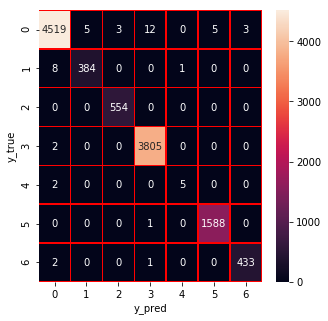

In [11]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [12]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9924115415159269
Precision of RF: 0.9924641723210192
Recall of RF: 0.9924115415159269
F1-score of RF: 0.9923720836357383
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.97      0.96       393
           2       0.97      1.00      0.98       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.93      0.96       436

    accuracy                           0.99     11333
   macro avg       0.96      0.94      0.95     11333
weighted avg       0.99      0.99      0.99     11333



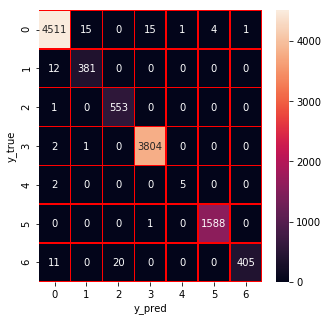

In [13]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [14]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9920585899585282
Precision of ET: 0.9920197520868573
Recall of ET: 0.9920585899585282
F1-score of ET: 0.9920217765183937
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.97      0.97       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.96      0.93      0.94     11333
weighted avg       0.99      0.99      0.99     11333



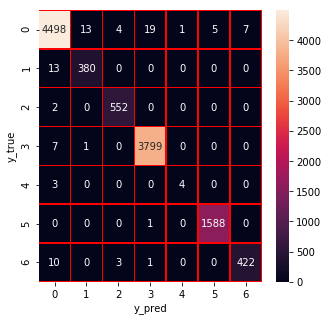

In [15]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [16]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9947939645283684
Precision of XGBoost: 0.994785642359916
Recall of XGBoost: 0.9947939645283684
F1-score of XGBoost: 0.9947770558136226
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



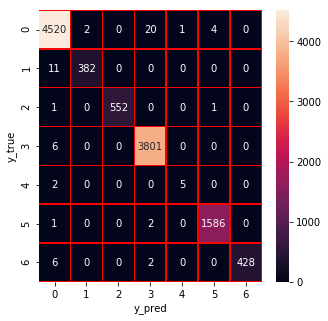

In [17]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [18]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [19]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,ExtraTrees,RandomForest,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [20]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [21]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [22]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9960292949792641
Precision of Stacking: 0.9960126519428796
Recall of Stacking: 0.9960292949792641
F1-score of Stacking: 0.9960148981765187
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



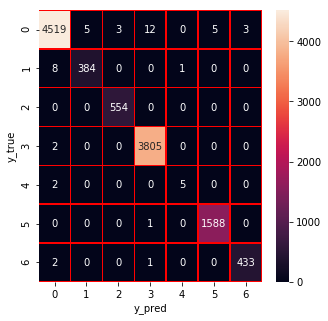

In [23]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [24]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [25]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [26]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.1235, 'Bwd Packet Length Std'), (0.0853, 'Bwd Packet Length Min'), (0.0574, 'Average Packet Size'), (0.05, 'Init_Win_bytes_backward'), (0.0492, 'Bwd Packet Length Mean'), (0.0401, 'Init_Win_bytes_forward'), (0.0397, 'PSH Flag Count'), (0.038, 'Bwd Packets/s'), (0.034, 'Bwd Header Length'), (0.028, 'Avg Bwd Segment Size'), (0.0264, 'Packet Length Mean'), (0.0235, 'Packet Length Variance'), (0.0228, 'Fwd Header Length'), (0.0209, 'Bwd Packet Length Max'), (0.0193, 'min_seg_size_forward'), (0.0182, 'ACK Flag Count'), (0.017, 'act_data_pkt_fwd'), (0.0157, 'Fwd Header Length.1'), (0.0128, 'Packet Length Std'), (0.0122, 'Total Length of Fwd Packets'), (0.0117, 'Fwd PSH Flags'), (0.0108, 'Fwd Packet Length Max'), (0.0108, 'Fwd IAT Mean'), (0.0106, 'Total Fwd Packets'), (0.0106, 'Flow IAT Max'), (0.01, 'Subflow Fwd Bytes'), (0.0095, 'Fwd IAT Max'), (0.0094, 'Subflow Bwd Bytes'), (0.0094, 'Max Packet Length'), (0.0092, 'Subflow Bwd Packets'), (0.009, 'Min Pac

In [27]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [28]:
len(f_list)

77

In [29]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [30]:
X_fs = df[fs].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [32]:
X_train.shape

(45328, 38)

In [33]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [34]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [35]:
X_train, y_train = smote.fit_sample(X_train, y_train)

In [36]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.9959410570899144
Precision of DT: 0.9959421882780577
Recall of DT: 0.9959410570899144
F1-score of DT: 0.995922941273118
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



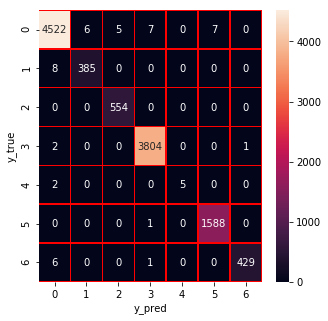

In [37]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [38]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9963822465366629
Precision of RF: 0.9963638997836398
Recall of RF: 0.9963822465366629
F1-score of RF: 0.9963668543569548
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



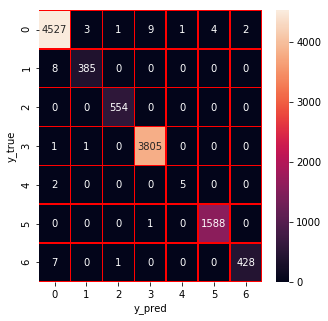

In [39]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [40]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.995764581311215
Precision of ET: 0.9957533838731291
Recall of ET: 0.995764581311215
F1-score of ET: 0.9957536562646003
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.97      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



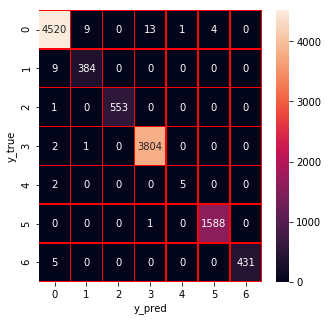

In [41]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [42]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9945292508603194
Precision of XGBoost: 0.9945034026564313
Recall of XGBoost: 0.9945292508603194
F1-score of XGBoost: 0.9944940662484604
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.93      0.95     11333
weighted avg       0.99      0.99      0.99     11333



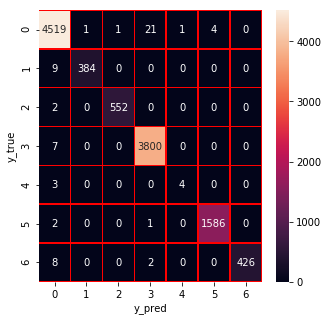

In [43]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [44]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [45]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,ExtraTrees,RandomForest,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [46]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [47]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9955881055325156
Precision of Stacking: 0.9955944258266153
Recall of Stacking: 0.9955881055325156
F1-score of Stacking: 0.9955625491897051
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       1.00      0.97      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       0.99      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



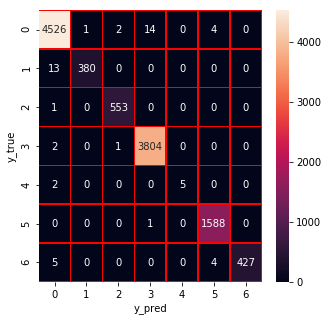

In [48]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()